# Week 13 Report

---

## Evolution of the Frontend

When we first built the **ML Prediction Dashboard**, the frontend was extremely minimal: few color variations and a design that, while functional, felt too bare-bones for a customer-facing product. It lacked the polish necessary to instill confidence.

To address this, we decided to completely rethink the visual style, starting with the branding, to deliver a more cohesive and engaging user experience.

The first step toward a more **customer-friendly** experience was to add a logo that immediately makes it clear what the project is about.

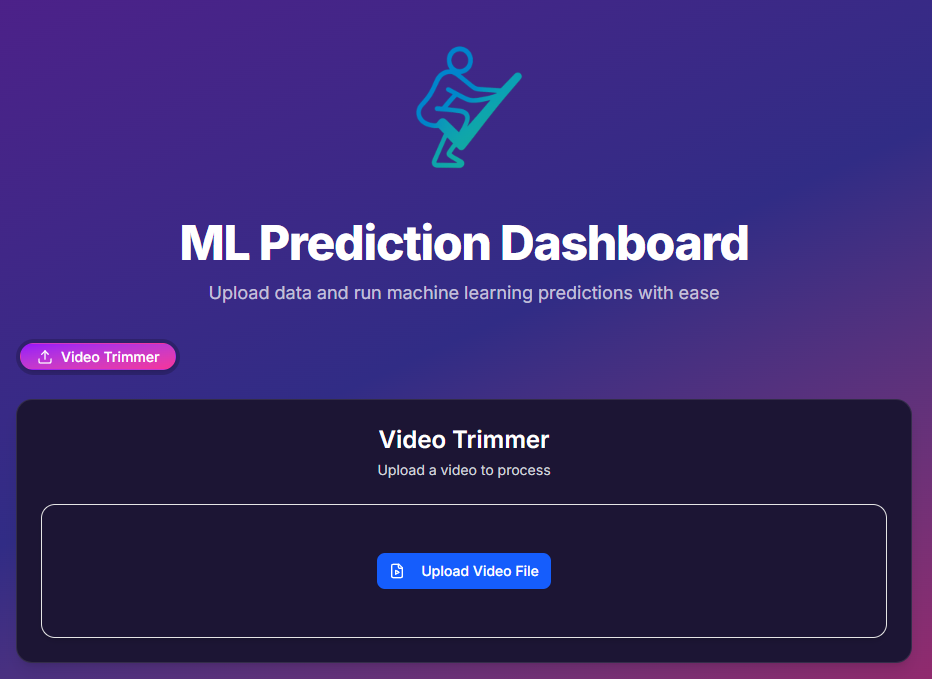

Next, we introduced a completely new color palette: a dark purple-to-blue gradient to add depth and create an elegant contrast with text and buttons. 
This is the final result, which aims to inspire more confidence in our model from users:

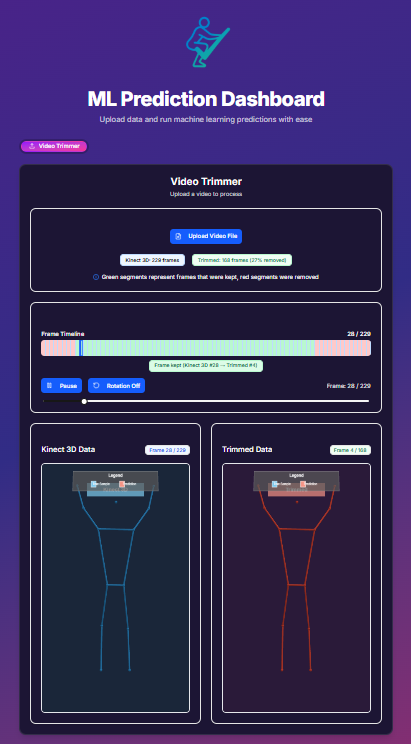

---

## Good vs. Bad Exercise Prediction: Kinect Dense Model

### Define functions and load data

We begin by defining a set of helper functions and then load our pre-processed data:

1. **`load_trimmed_sequences`**  
   Reads pre-trimmed CSVs (trimmed using our cutting tool). Files prefixed with `G` are “good” and those with `W` are “bad.” For each sequence, we drop the `FrameNo` column, then sample or pad to exactly 10 evenly spaced frames. The result is an array `X` of shape `(n_sequences, 10, 39)`, and a label vector `y` with 1 for good and 0 for bad.

2. **`build_dense`**  
   Builds a fully connected network with a given number of hidden layers and a total parameter budget. Each layer has the same number of neurons, calculated so that the total parameters stay close to the budget (e.g. 10 000). This lets us vary the depth while keeping model size roughly constant.

3. **`cross_validate_dense`**  
   Performs Stratified K-Fold cross-validation for a dense model (specified depth and budget). On each fold, it splits into train/validation, scales the data, trains the model with early stopping, then collects predictions and metrics on the validation set.

4. **`plot_average_loss`**  
   Computes and plots the mean training and validation loss (cross-entropy) across folds, as a function of epoch.

5. **`plot_average_precision_recall`**  
   Similar to `plot_average_loss`, but plots precision and recall curves averaged over folds.

6. **`plot_aggregated_roc`**  
   Takes the lists of true-label arrays (`y_trues`) and predicted-probability arrays (`y_probs`) returned by `cross_validate_dense`, concatenates them, then computes and plots the overall ROC curve along with the AUC.

7. **`plot_confusion_matrix`**  
   Receives the lists of true labels (`y_trues`) and predicted labels (`y_preds`) from all folds, builds each fold’s confusion matrix, sums them, and displays the combined confusion matrix.

8. **`plot_cv_summary`**  
   Arranges the four summary plots (loss, precision/recall, ROC, confusion matrix) in a 2×2 grid with a title indicating model depth and parameter count.

9. **`print_results`**  
   Calculates and prints the mean of each CV metric (loss, accuracy, precision, recall, F1-score, AUC) across all folds.

Once the functions are defined, we call `load_trimmed_sequences` to get `X, y`, and set our training constants (`EPOCHS`, `BATCH_SIZE`, `PATIENCE`) for later use.

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay, f1_score
)
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from joblib import dump

def load_trimmed_sequences(data_dir, sequence_length=10):
    """
    Load pre-trimmed joint-coordinate CSVs and return:
      X: ndarray (n_samples, sequence_length, 39)
      y: ndarray (n_samples,) integer labels (1=Good, 0=Bad)
    """
    data_dir = Path(data_dir)
    paths = sorted(data_dir.glob("[GW]*_trimmed.csv"))

    X_list, y_list = [], []
    for p in paths:
        stem = p.stem
        if stem.startswith("G"):
            label = 1
        elif stem.startswith("W"):
            label = 0
        else:
            continue  # ignore unexpected files

        df = pd.read_csv(p)
        df = df.drop(columns=["FrameNo"], errors="ignore")
        seq = df.values
        F, D = seq.shape

        # sample or pad to fixed length
        if F >= sequence_length:
            idx = np.linspace(0, F - 1, sequence_length, dtype=int)
            proc_seq = seq[idx]
        else:
            pad = np.zeros((sequence_length - F, D), dtype=seq.dtype)
            proc_seq = np.vstack([seq, pad])

        X_list.append(proc_seq)
        y_list.append(label)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=int)
    return X, y


def build_dense(n_hidden_layers=2, param_budget=10_000, input_shape=(10, 39)):
    """
    Build and compile a Sequential dense model targeting ~param_budget parameters.

    Returns a tf.keras.Model.
    """
    D = np.prod(input_shape)
    L = n_hidden_layers

    # solve for hidden units per layer
    if L == 1:
        h = int((param_budget - 1) / (D + 1))
    else:
        a, b, c = (L-1), (D+L+1), (1 - param_budget)
        disc = b*b - 4*a*c
        h = int((-b + np.sqrt(disc)) / (2*a))
    h = max(1, h)

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        *[layers.Dense(h, activation="relu") for _ in range(L)],
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )
    return model


def cross_validate_dense(
    X, y,
    n_hidden_layers,
    param_budget=10_000,
    n_splits=5,
    epochs=50,
    batch_size=32,
    patience=10,
    input_shape=(10,39),
    random_state=42
):
    """
    Stratified K-Fold CV for the dense model.

    Returns:
      fold_metrics: list of (loss, accuracy, precision, recall, f1, auc)
      histories:    list of history.history dicts
      y_trues:      list of true-label arrays per fold
      y_preds:      list of predicted-label arrays per fold
      y_probs:      list of predicted-prob arrays per fold
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_metrics, histories = [], []
    y_trues, y_preds, y_probs = [], [], []

    for train_i, test_i in skf.split(X, y):
        # split and scale
        X_tr_raw, X_val_raw = X[train_i], X[test_i]
        y_tr, y_val         = y[train_i], y[test_i]
        flat_tr = X_tr_raw.reshape(-1, X.shape[-1])
        flat_val = X_val_raw.reshape(-1, X.shape[-1])
        scaler = StandardScaler().fit(flat_tr)
        X_tr = scaler.transform(flat_tr).reshape(X_tr_raw.shape)
        X_val = scaler.transform(flat_val).reshape(X_val_raw.shape)

        # build & fit
        model = build_dense(n_hidden_layers, param_budget, input_shape)
        es = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=epochs, batch_size=batch_size,
            verbose=0, callbacks=[es]
        )

        # predict & compute metrics
        y_prob = model.predict(X_val, verbose=0).ravel()
        y_pred = (y_prob >= 0.5).astype(int)
        f1 = f1_score(y_val, y_pred)

        loss, acc, prec, rec, auc_val = model.evaluate(X_val, y_val, verbose=0)
        fold_metrics.append((loss, acc, prec, rec, f1, auc_val))
        histories.append(history.history)

        y_trues.append(y_val)
        y_preds.append(y_pred)
        y_probs.append(y_prob)

    return fold_metrics, histories, y_trues, y_preds, y_probs


def plot_average_loss(histories, ax=None, title_prefix="Average Loss"):
    """Plot mean train & val loss over folds."""
    if ax is None: ax = plt.gca()
    min_e = min(len(h["loss"]) for h in histories)
    x = range(1, min_e+1)
    train = np.array([h["loss"][:min_e]     for h in histories]).mean(0)
    val   = np.array([h["val_loss"][:min_e] for h in histories]).mean(0)

    ax.plot(x, train, label="Train Loss")
    ax.plot(x, val,   label="Val Loss")
    ax.set(xlabel="Epoch", ylabel="Loss", title=f"{title_prefix} over {len(histories)} folds")
    ax.legend()


def plot_average_precision_recall(histories, ax=None, title_prefix="Avg Precision & Recall"):
    """Plot mean train & val precision/recall over folds."""
    if ax is None: ax = plt.gca()
    min_e = min(len(h["precision"]) for h in histories)
    x = range(1, min_e+1)
    tprec = np.array([h["precision"][:min_e]    for h in histories]).mean(0)
    vprec = np.array([h["val_precision"][:min_e] for h in histories]).mean(0)
    trec  = np.array([h["recall"][:min_e]       for h in histories]).mean(0)
    vrec  = np.array([h["val_recall"][:min_e]    for h in histories]).mean(0)

    ax.plot(x, tprec, label="Train Precision")
    ax.plot(x, vprec, label="Val Precision")
    ax.plot(x, trec,  label="Train Recall")
    ax.plot(x, vrec,  label="Val Recall")
    ax.set(xlabel="Epoch", ylabel="Metric", title=f"{title_prefix} over {len(histories)} folds")
    ax.legend()


def plot_aggregated_roc(y_trues, y_probs, ax=None, title="ROC Curve"):
    """Plot one ROC/AUC over all folds combined."""
    if ax is None: ax = plt.gca()
    y_true_all = np.concatenate(y_trues)
    y_prob_all = np.concatenate(y_probs)
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    ax.plot([0,1], [0,1], "k--", label="Chance")
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=title)
    ax.legend()


def plot_confusion_matrix(y_trues, y_preds, ax=None, labels=('Bad','Good'), title="Confusion Matrix"):
    """Plot aggregated confusion matrix over all folds."""
    if ax is None: ax = plt.gca()
    cms = [confusion_matrix(t, p) for t, p in zip(y_trues, y_preds)]
    total_cm = sum(cms)
    disp = ConfusionMatrixDisplay(total_cm, display_labels=labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(title)


def plot_cv_summary(histories, y_trues, y_preds, y_probs, depth, params):
    """
    2×2 summary: Loss, Precision/Recall, ROC & Confusion Matrix.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    plot_average_loss(histories,                ax=axs[0,0])
    plot_average_precision_recall(histories,    ax=axs[0,1])
    plot_aggregated_roc(y_trues, y_probs,       ax=axs[1,0])
    plot_confusion_matrix(y_trues, y_preds,     ax=axs[1,1])
    fig.suptitle(f"{depth}-layer model (~{params} params)", fontsize=16)
    plt.tight_layout()
    plt.show()


def print_results(fold_metrics, metric_names=None):
    """
    Print mean of each metric across folds.
    fold_metrics tuples: (loss, accuracy, precision, recall, f1, auc)
    """
    if metric_names is None:
        metric_names = ["bce_loss","accuracy","precision","recall","f1_score","auc"]
    mean_vals = {
        name: np.mean([fm[i] for fm in fold_metrics])
        for i, name in enumerate(metric_names)
    }
    print("Mean CV metrics:")
    for name in metric_names:
        print(f"  {name.title():<9}: {mean_vals[name]:.4f}")


X, y = load_trimmed_sequences("data/kinect_good_vs_bad_trimmed", sequence_length=10)

EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 10

### Try different model depths

We tested how the number of hidden layers affects performance by running 5-fold CV on models with 1–10 layers (each model has ~10,000 parameters total). We then computed the mean CV accuracy for each configuration and stored it in `mean_accuracies`.

In [ ]:
# Sweep over depths and compute mean CV accuracy
depths = range(1, 11)
mean_accuracies = []

for L in depths:
    fold_metrics, _, _, _, _ = cross_validate_dense(
        X, y,
        n_hidden_layers=L,
        param_budget=10_000,
        n_splits=5,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        patience=PATIENCE
    )
    # accuracy is at index 1
    accuracies = [m[1] for m in fold_metrics]
    mean_accuracies.append(np.mean(accuracies))

### Plot depth vs. accuracy and select best model

We plot the mean CV accuracy for each hidden‐layer count (1–10), then find which depth gives the highest average accuracy and print the best depth and its CV score. We got the following result:

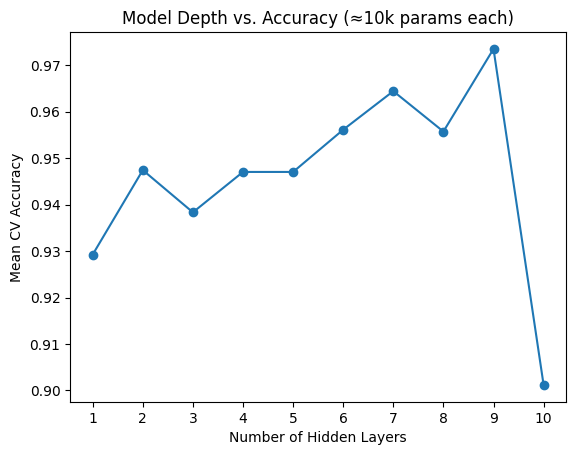

Best model depth: 9 hidden layers → mean CV accuracy = 0.9735

And the model architecture for 9 layers and roughly 10k params looks like this:

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_70 (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>)            │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">390</span>)            │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_505 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │         <span style="color: #00af00; text-decoration-color: #00af00">7,038</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_507 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_510 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_511 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">18</span>)             │           <span style="color: #00af00; text-decoration-color: #00af00">342</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_513 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">19</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>

In [ ]:
fig, ax = plt.subplots()
ax.plot(depths, mean_accuracies, '-o')
ax.set_xticks(depths)
ax.set_xlabel("Number of Hidden Layers")
ax.set_ylabel("Mean CV Accuracy")
ax.set_title("Model Depth vs. Accuracy (≈10k params each)")
plt.show()

# Find which depth gave the highest mean accuracy
best_idx = int(np.argmax(mean_accuracies))
best_depth = list(depths)[best_idx]
best_acc   = mean_accuracies[best_idx]

print(f"Best model depth: {best_depth} hidden layers → mean CV accuracy = {best_acc:.4f}")

### 9-layer model CV (10,000 params)

With the optimal depth of 9 layers, we perform 10-fold cross-validation to gather detailed metrics, training histories, and predictions. Here we use the full parameter budget of 10,000, just like before.

In [ ]:
LAYERS = best_depth
PARAMS = 10000

fold_metrics, histories, y_trues, y_preds, y_probs = cross_validate_dense(
    X, y,
    n_hidden_layers=LAYERS,
    param_budget=PARAMS,
    n_splits=10,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE
)

### Evaluation of 10,000 param model

We got the following result:

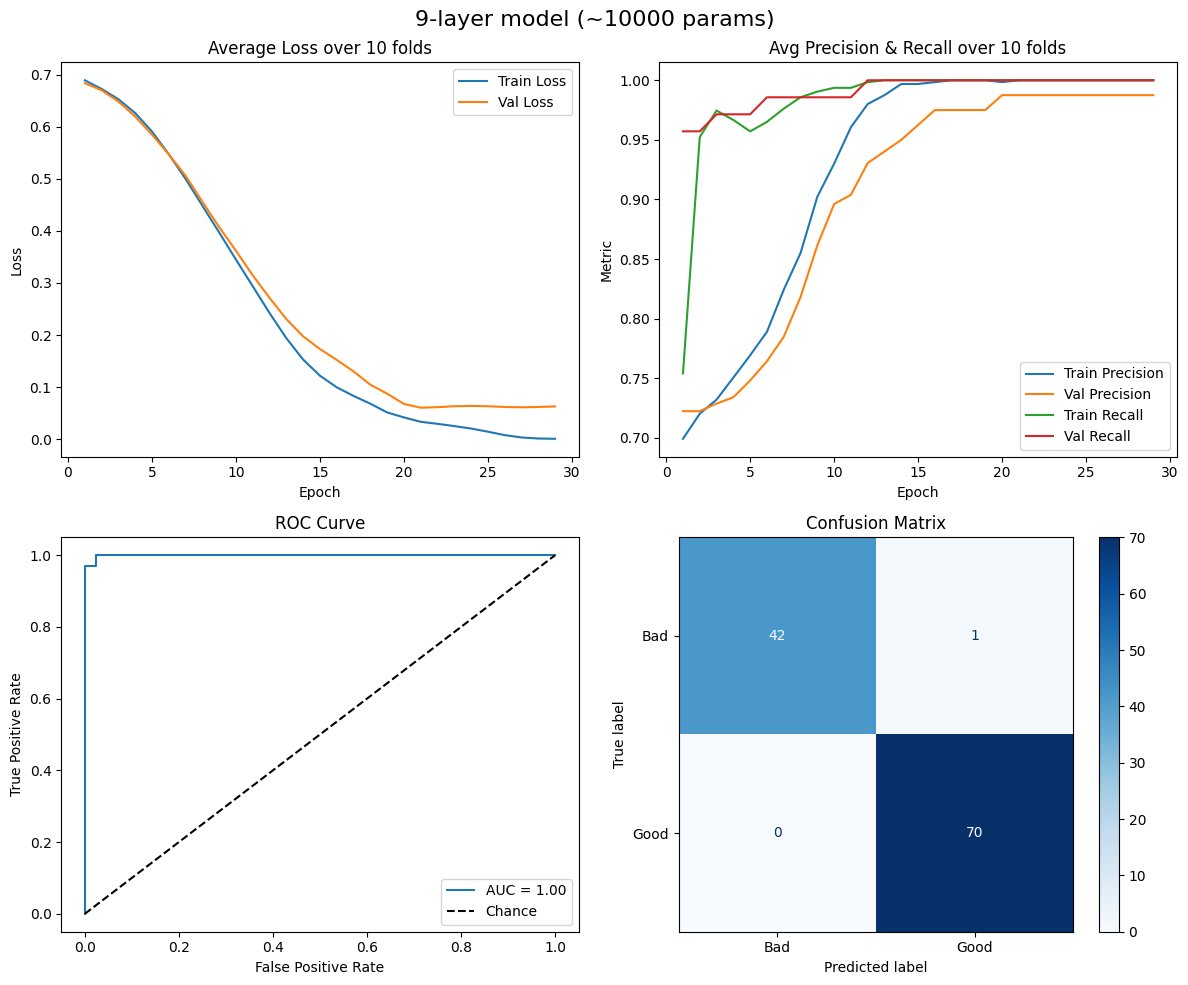

Mean CV metrics:
* Bce_Loss : 0.0272
* Accuracy : 0.9909
* Precision: 0.9875
* Recall   : 1.0000
* F1_Score : 0.9933
* Auc      : 0.9964

In [ ]:
plot_cv_summary(histories, y_trues, y_preds, y_probs, LAYERS, PARAMS)
print_results(fold_metrics)

### Try with 2,000 params

We also wanted to try a version with just 2,000 parameters to match the CNN and RNN versions, for a more fair comparison between them. We use 9 layers here too.

In [ ]:
LAYERS = best_depth
PARAMS = 2000

fold_metrics, histories, y_trues, y_preds, y_probs = cross_validate_dense(
    X, y,
    n_hidden_layers=LAYERS,
    param_budget=PARAMS,
    n_splits=10,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE
)

### Evaluation of 2,000 param model

These were our results:

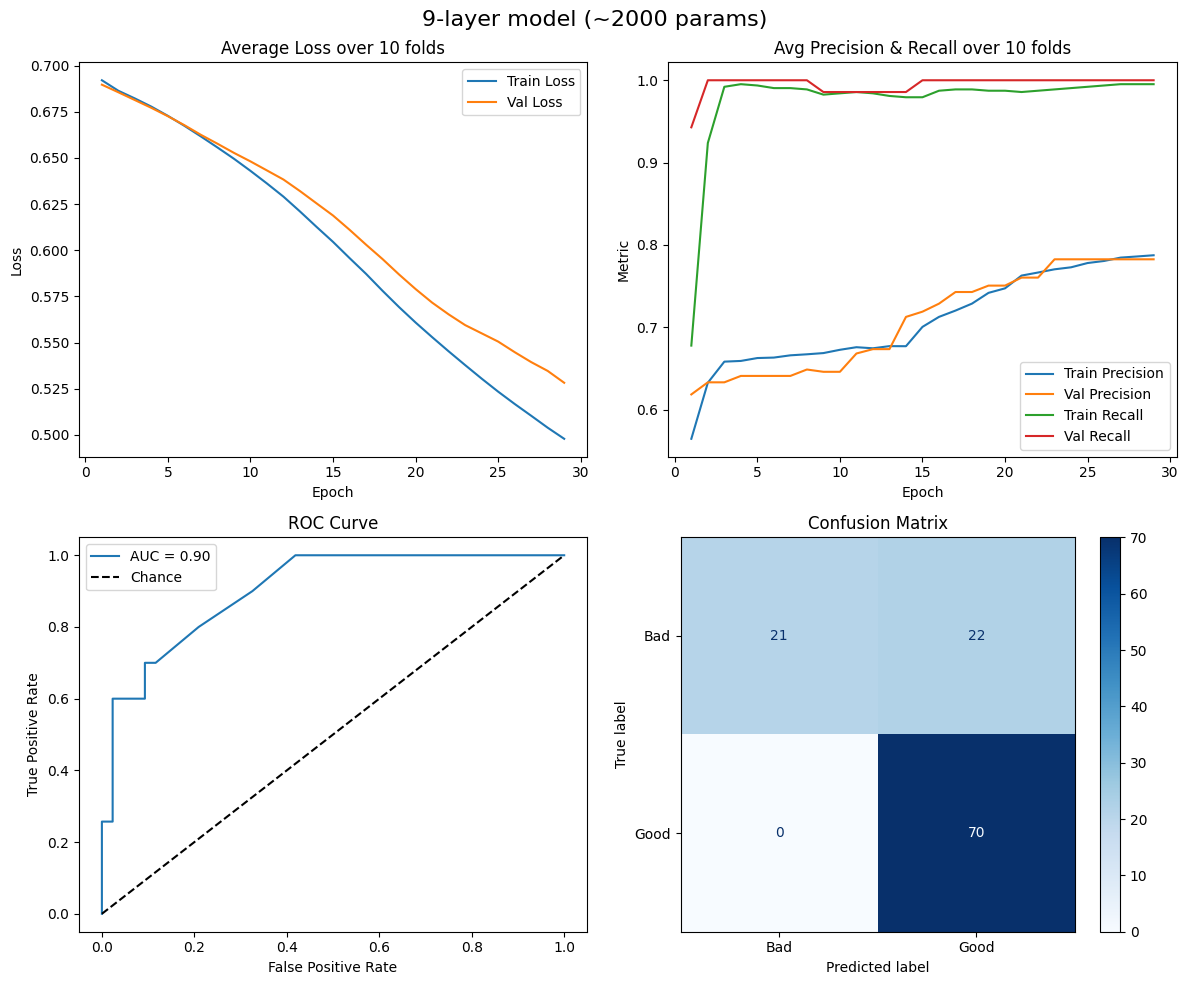

Mean CV metrics:
* Bce_Loss : 0.4432
* Accuracy : 0.8083
* Precision: 0.7967
* Recall   : 1.0000
* F1_Score : 0.8771
* Auc      : 0.8393

The architecture for the 2,000 param version looks like this:

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">390</span>)            │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>)              │         <span style="color: #00af00; text-decoration-color: #00af00">1,564</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">20</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">20</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">20</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">20</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">20</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">20</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">20</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">20</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)              │             <span style="color: #00af00; text-decoration-color: #00af00">5</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>

In [ ]:
plot_cv_summary(histories, y_trues, y_preds, y_probs, LAYERS, PARAMS)
print_results(fold_metrics)

### Final training on full dataset

We fit a `StandardScaler` on all of `X` and apply it to get `X_scaled`, build the final dense model using the chosen depth and 10 000-parameter budget, train it on the entire scaled dataset, then save both the trained model and the scaler for later use.  

In [ ]:
# ——— Final training on full dataset ———

# 1) Fit scaler on all of X
flat_all   = X.reshape(-1, X.shape[-1])
final_scaler = StandardScaler()
flat_scaled = final_scaler.fit_transform(flat_all)
X_scaled    = flat_scaled.reshape(X.shape)

# 2) Build final model
depth = best_depth
final_model = build_dense(
    n_hidden_layers=depth,
    param_budget=10_000,
    input_shape=(10, 39)
)

# 3) Train on the full, scaled dataset
final_model.fit(
    X_scaled, y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# 4) Save both model and scaler
final_model.save(os.path.join("models", "kinect_dense_good_vs_bad_model.keras"))
dump(final_scaler, os.path.join("models", "kinect_dense_good_vs_bad_scaler.pkl"))
final_model.summary()
print("Model and scaler saved successfully!")

-----

## RNN and CNN models

We did the same things for RNN and CNN. The code is not included here, but it can be found in `ML/good_bad_exercise.ipynb`.

### RNN

#### Architecture

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (<span style="color: #0087ff; text-decoration-color: #0087ff">LSTM</span>)                     │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">10</span>)             │         <span style="color: #00af00; text-decoration-color: #00af00">2,000</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">11</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>

#### Results on first fold

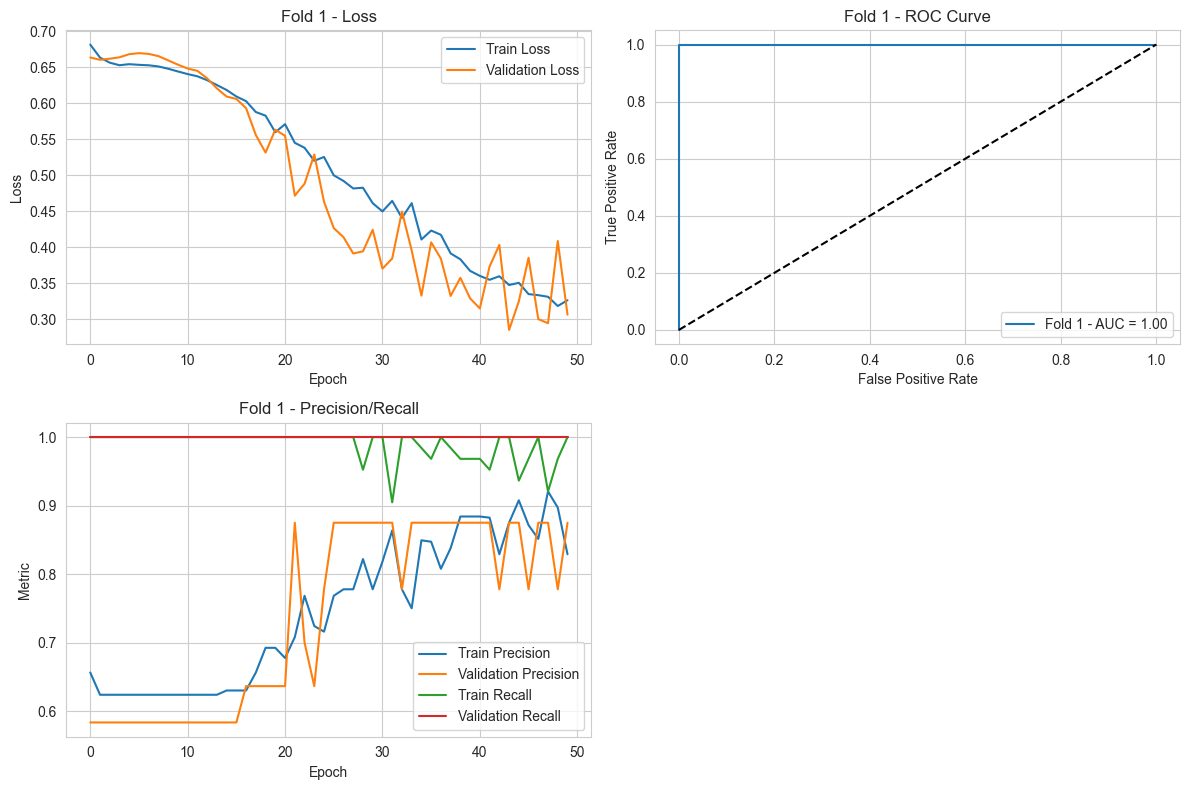

#### Confusion Matrix

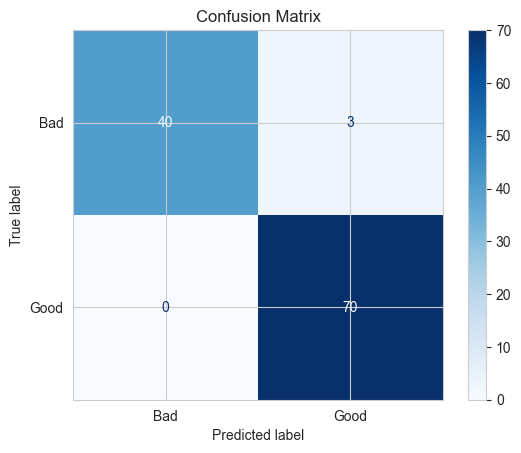

#### Metrics

--- Overall Metrics ---
* Overall Precision: 0.9589
* Overall Recall: 1.0000
* Overall F1-score: 0.9790
* Overall AUC: 0.9651

### CNN

#### Architecture

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv1D</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">10</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>)          │           <span style="color: #00af00; text-decoration-color: #00af00">944</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8</span>)              │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">GlobalAveragePooling1D</span>)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)              │             <span style="color: #00af00; text-decoration-color: #00af00">9</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>

#### Results on first fold

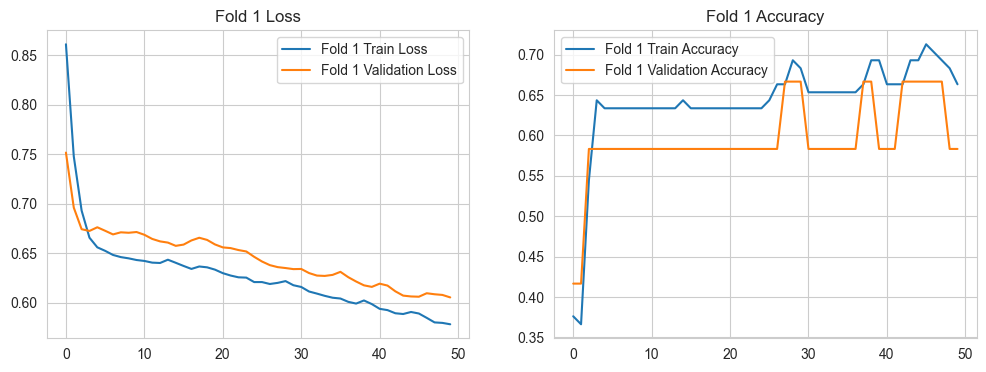

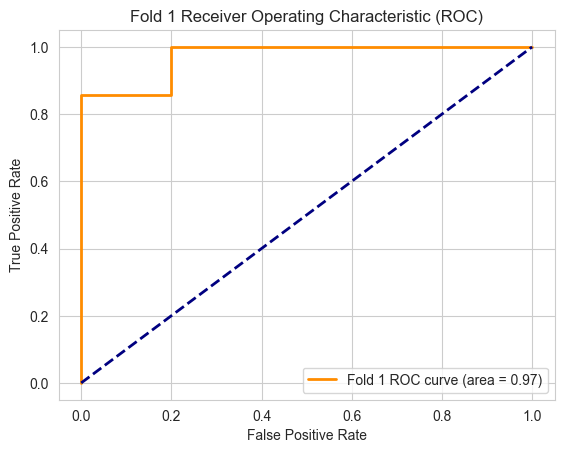

#### Confusion Matrix

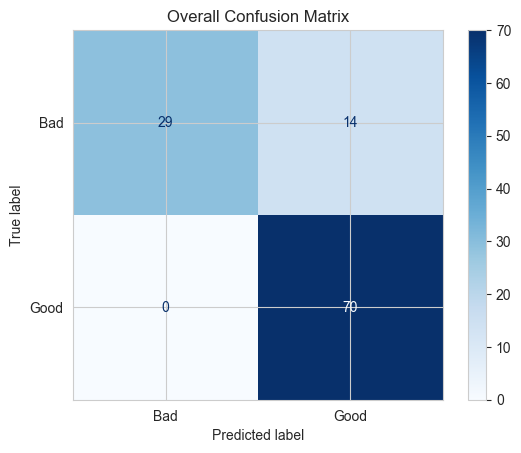

#### Metrics

--- Overall Evaluation Metrics ---
* Overall Precision: 0.8333
* Overall Recall: 1.0000
* Overall F1-score: 0.9091
* Overall AUC: 0.9791

## Augmentation Script

---

## Objective
To enhance motion capture datasets by applying data augmentation techniques such as mirroring, rotation, and scaling to joint coordinate data stored in CSV files.

---

## Key Features

### Configuration Management
- **`DATA_DIR_CONFIG`**: Defines input/output directories for unprocessed and processed data.
- **`aug_config`**: Specifies augmentation types (mirror, rotate, scale) and their parameters.

### Data Handling
- **`load_data`**: Loads data from specified directories and supports `.csv` and `.xls/.xlsx` formats.
- **`save_data`**: Saves augmented data to configured directories, creating directories if needed.

### Augmentation Functions
1. **Mirroring**:
   - Reflects joint coordinates across specified axes (`x`, `y`, `z`).
   - **Functions**: `mirror_to_new_df`, `add_mirror_augmentation`.

2. **Rotation**:
   - Rotates joint coordinates around specified axes using rotation matrices.
   - **Functions**: `rotate_to_new_df`, `add_rotation_augmentation`.

3. **Scaling**:
   - Scales joint coordinates by configurable factors for each axis.
   - **Functions**: `scale_to_new_df`, `add_scale_augmentation`.

---

## Workflow
- **Main Function**:
  - Processes all CSV files in the `unprocessed.bad_good` directory.
  - Sequentially applies mirroring, rotation, and scaling augmentations.
  - Saves augmented data to respective directories (`mirror`, `rotate`, `scale`).
- **Error Handling**:
  - Validates configuration paths, file existence, and supported file formats.

---

## Example Usage
1. Place input files in the `unprocessed.bad_good` directory.
2. Run the script:
   ```bash
   python augmentation.py